* ##### Assignment: 8.2 Time Series Modeling
* ##### Name: Barath Anandaraman
* ##### Course: DSC630-T301
* ##### Week8: Time Series
* ##### Date: 04/30/2025

---

#### Load necessary packages

In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

#### Load the US Retail Sales dataset

In [2]:
retail_df = pd.read_csv('us_retail_sales.csv')
retail_df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0


#### The original dataset has years in rows and months as columns.  We'll melt it to long format for time series analysis

In [3]:
# Convert wide to long format
retail_melted = retail_df.melt(id_vars=['YEAR'], var_name='Month', value_name='Sales')
# Map month names to month names
month_num = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
retail_melted['Month_Num'] = retail_melted['Month'].map(month_num)
# Create a proper datetime column
retail_melted['Date'] = pd.to_datetime(dict(year=retail_melted['YEAR'], month=retail_melted['Month_Num'], day=1))

# Sort the table by date
retail_melted = retail_melted.sort_values('Date')

In [4]:
retail_melted.head()

,YEAR,Month,Sales,Month_Num,Date
0,1992,JAN,146925.0,1,1992-01-01
30,1992,FEB,147223.0,2,1992-02-01
60,1992,MAR,146805.0,3,1992-03-01
90,1992,APR,148032.0,4,1992-04-01
120,1992,MAY,149010.0,5,1992-05-01


##### Check for NAs and drop them

In [5]:
# Check for NAs
print(retail_melted.columns[retail_melted.isna().any()].tolist())

['Sales']


In [6]:
retail_melted['Sales'].isna().sum()

np.int64(6)

#### Column Sales has 6 rows of NA and has to be dropped

In [7]:
retail_melted = retail_melted.dropna(subset=['Sales'])

---

#### Step1. Plot the data with proper labeling and make some observations on the graph.

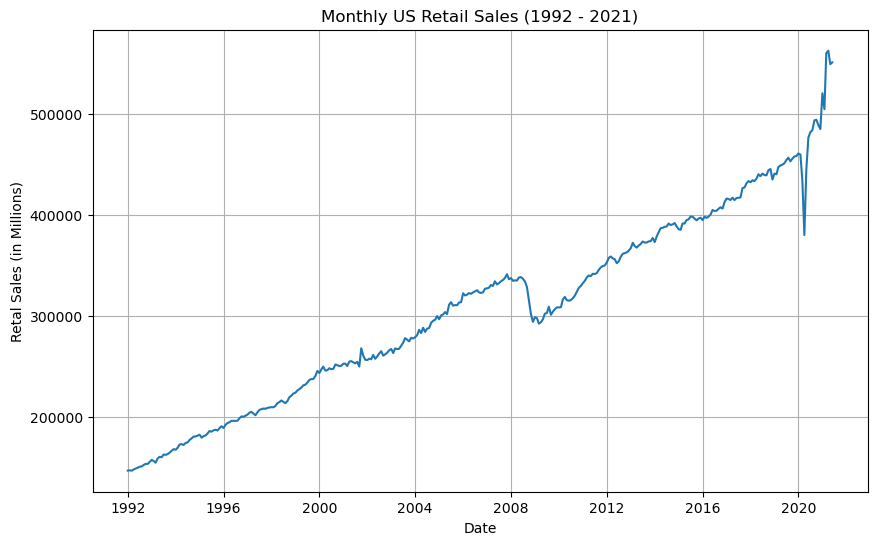

In [8]:
plt.figure(figsize=(10,6))
plt.plot(retail_melted['Date'], retail_melted['Sales'])
plt.title('Monthly US Retail Sales (1992 - 2021)')
plt.xlabel('Date')
plt.ylabel('Retal Sales (in Millions)')
plt.grid(True)
plt.show()

#### Achieved so far:
##### Loaded the data in dataframe
##### Reshaped the data from wide format to long format
##### Dropped NA rows
##### Plotted monthly retail sales from 1992 to 2021

#### Observations from graph
##### Sales show a dip around 2008 and 2020
##### - 2008, could be due to the housing crisis 
##### - 2020, could be due to COVid crisis
##### There is a steady upward trend over the years - retail sales generally increase over time

---

#### Step2. Split this data into a training and test set. Use the last year of data (July 2020 – June 2021) of data as your test set and the rest as your training set.

In [9]:
# Per requirement Define Test set: July 2020 till June 2021
test = retail_melted[(retail_melted['Date'] >= '2020-07-01') & (retail_melted['Date'] <= '2021-06-01')]
# Define Train set as everything else
train = retail_melted[~retail_melted['Date'].isin(test['Date'])]


---

#### Step3. Use the training set to build a predictive model for the monthly retail sales.

In [10]:
# Fit model using training data
model = ExponentialSmoothing(train['Sales'],
                            trend = 'add',
                            seasonal='add',
                            seasonal_periods=12).fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


---

#### Step4. Use the model to predict the monthly retail sales on the last year of data.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


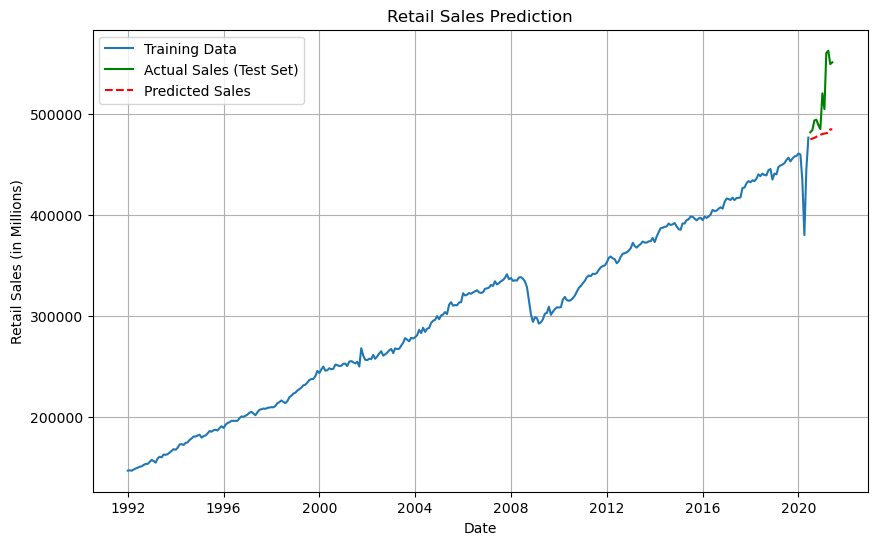

In [11]:
# Predict on test period
predictions = model.forecast(steps=12)

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(train['Date'], train['Sales'], label = 'Training Data')
plt.plot(test['Date'], test['Sales'], label = 'Actual Sales (Test Set)', color = 'green')
plt.plot(test['Date'], predictions, label = 'Predicted Sales', color = 'red' , linestyle='--')
plt.title('Retail Sales Prediction')
plt.xlabel('Date')
plt.ylabel('Retail Sales (in Millions)')
plt.legend()
plt.grid(True)
plt.show()

---

#### Step5. Report the RMSE of the model predictions on the test set.

In [12]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Sales'], predictions))
rmse

np.float64(45156.97171858635)

---

#### Achieved so far:
##### Model used: Holt-Winters Exponential Smoothing (captures both trend and seasonality)
##### Prediction Period: July 2020 - June 2021
##### Root Mean Squared Error on Test Set: 45,156.97, this means the typical prediction error is around $45,157 million

#### Final Summary
##### Training data: January 1992 to June 2020
##### Test data: July 2020 to June 2021
##### Observation: The model closely tracks the trend, but some deviation occurs possibly due to COVID-era volatility

---

#### Additionally check for Seasonal Volatility using Box Plot

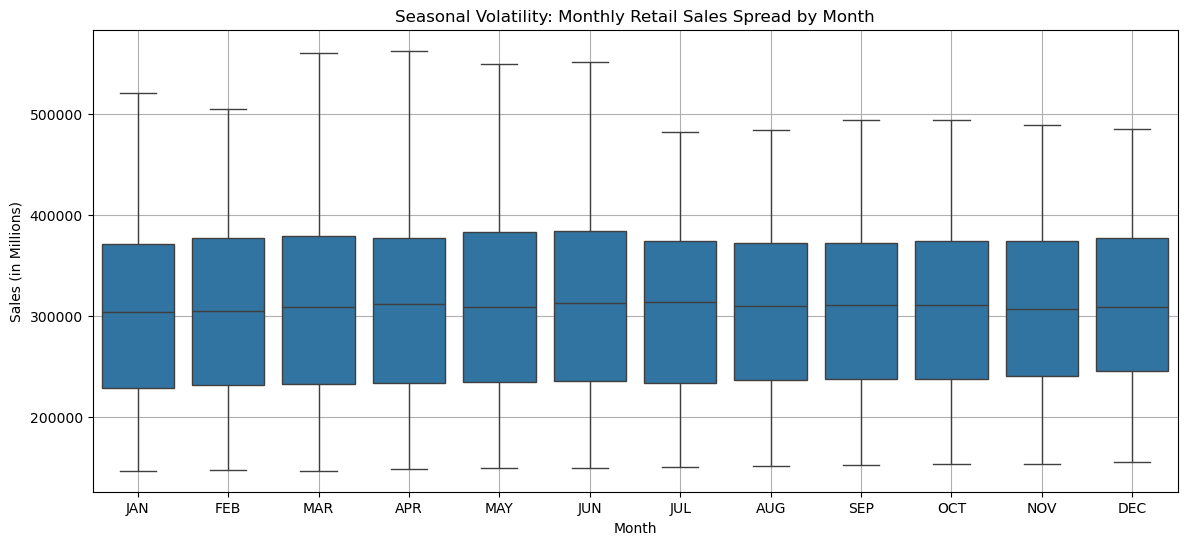

In [13]:
import seaborn as sns
# Ensure month order
df_melted = retail_melted.copy()
df_melted['Month'] = pd.Categorical(df_melted['Month'],
                                   categories = ['JAN','FEB','MAR','APR','MAY','JUN',
                                                'JUL','AUG','SEP','OCT','NOV','DEC'],
                                   ordered = True)
plt.figure(figsize=(14,6))
sns.boxplot(x='Month', y='Sales', data = df_melted)
plt.title('Seasonal Volatility: Monthly Retail Sales Spread by Month')
plt.ylabel('Sales (in Millions)')
plt.grid(True)
plt.show()

#### Noticed certain months March, May, June have higher retail sales this could be seasonality